<a href="https://colab.research.google.com/github/zaidbhat1234/Image2StyleGAN/blob/main/Image2Style_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mounting your google drive containing the code files.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Image2StyleGAN-g

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1nibnfkNoMwImTwkFyHa0Xu2iH3QR_dMi/Image2StyleGAN


##The code should be arranged in this order of directories

In [2]:
from stylegan_layers import G_mapping,G_synthesis
import torch
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import torchvision
from torchvision import models
from torchvision.utils import save_image
import numpy as np
from math import log10
import matplotlib.pyplot as plt


##Setup up the network on GPU

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all = nn.Sequential(OrderedDict([('g_mapping', G_mapping()),
    #('truncation', Truncation(avg_latent)),
    ('g_synthesis', G_synthesis(resolution=1024))
    ]))

#Load the pre-trained model
g_all.load_state_dict(torch.load('weight_files/pytorch/karras2019stylegan-ffhq-1024x1024.pt', map_location=device))
g_all.eval()
g_all.to(device)
g_mapping, g_synthesis = g_all[0],g_all[1]


##Read Images for inverting to latent space W+ and using in various experiments

In [4]:
#Read a sample image we want to find a latent vector for
# IMages : Portrait00002.png
img_path = 'images/ryan_gosling.png'
with open(img_path,"rb") as f:
  image=Image.open(f)
  image=image.convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)
print(image.shape)

path = img_path[3:-4]
print(path)

torch.Size([1, 3, 780, 780])
ges/ryan_gosling


##Generate random images using random W vectors

In [5]:
g_all = g_all.to(device)  # Make 100% sure it's on the same device
g_all.eval()              # Set it to evaluation mode


for i in range(20):
  z = torch.randn(1,512,device = device)
  img = g_all(z)
  img = (img +1.0)/2.0
  save_image(img.clamp(0,1),"save_image/random_SG1-{}.png".format(i+1))

##VGG Perceptual loss network to give feature vectors from 4 parts of the pre-trained VGG-16 from 2,4,14,21

In [6]:
class VGG16_perceptual(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16_perceptual, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 4):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 14):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(14, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_1 = h
        h = self.slice2(h)
        h_relu1_2 = h
        h = self.slice3(h)
        h_relu3_2 = h
        h = self.slice4(h)
        h_relu4_2 = h
        return h_relu1_1, h_relu1_2, h_relu3_2, h_relu4_2

##Loss function to calculate MSE and Perceptual losses

In [7]:
def loss_function(syn_img, img, img_p, MSE_loss, upsample, perceptual):

  #UpSample synthesized image to match the input size of VGG-16 input.
  #Extract mid level features for real and synthesized image and find the MSE loss between them for perceptual loss.
  #Find MSE loss between the real and synthesized images of actual size
  syn_img_p = upsample(syn_img)
  syn0, syn1, syn2, syn3 = perceptual(syn_img_p)
  r0, r1, r2, r3 = perceptual(img_p)
  mse = MSE_loss(syn_img,img)

  per_loss = 0
  per_loss += MSE_loss(syn0,r0)
  per_loss += MSE_loss(syn1,r1)
  per_loss += MSE_loss(syn2,r2)
  per_loss += MSE_loss(syn3,r3)

  return mse, per_loss

##Calculate PSNR

In [8]:
def PSNR(mse, flag = 0):
  #flag = 0 if a single image is used and 1 if loss for a batch of images is to be calculated
  if flag == 0:
    psnr = 10 * log10(1 / mse.item())
  return psnr

In [9]:
psnr_total = []

##Contribution 1: W+ Latent Code Optimization & Noise Map Optimiztaion

In [10]:
def embedding_function(image, num_steps=5000, lr=0.01, decay_step=2500):
    upsample = torch.nn.Upsample(scale_factor=256/1024, mode='bilinear')
    img_p = image.clone()
    img_p = upsample(img_p)

    perceptual = VGG16_perceptual().to(device)
    MSE_loss = nn.MSELoss(reduction="mean")

    latents = torch.zeros((1, 18, 512), requires_grad=True, device=device)
    optimizer = optim.Adam({latents}, lr=lr, betas=(0.9, 0.999), eps=1e-8)

    loss_list = []
    psnr_list = []

    for e in range(num_steps):
        optimizer.zero_grad()

        syn_img = g_synthesis(latents)
        syn_img = (syn_img + 1.0) / 2.0

        mse, per_loss = loss_function(syn_img, image, img_p, MSE_loss, upsample, perceptual)

        psnr = PSNR(mse, flag=0)

        loss =  0.95 * mse +  0.05 * per_loss

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        psnr_list.append(psnr)

        if e == decay_step:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
            print(f"Learning rate decayed at step {e}")

        if (e + 1) % 500 == 0:
            print(f"iter {e+1}: loss={loss.item():.6f}, mse={mse.item():.6f}, perceptual={per_loss.item():.6f}, psnr={psnr:.2f}")
            save_image(syn_img.clamp(0,1), f"save_image/embedding_step_{e+1}.png")

    plt.plot(loss_list, label='Total Loss')
    plt.plot(psnr_list, label='PSNR')
    plt.xlabel('Iteration')
    plt.legend()
    plt.title('Embedding Loss and PSNR over time')
    plt.grid(True)
    plt.show()

    return latents


In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from stylegan_layers import NoiseLayer

def optimize_noise(generator, latent, target_image,
                   num_steps=3000,
                   lr=0.01,
                   normalize_every=20):
    print("Beginning noise optimization...")

    with torch.no_grad():
        _ = generator(latent)

    noise_layers = []
    optimized_noise = []

    # loops through all of the modules and if it's a noise layer --> initialize with noise map
    for module in generator.modules():
        if isinstance(module, NoiseLayer): # make sure noise layer exists in the generator
            b, c, h, w = module._last_input_size
            if module.noise is None or module.noise.shape[-2:] != (h, w):
                module.noise = torch.randn(1, 1, h, w, device=target_image.device) # initialize the noise!!!

            n = module.noise.clone().detach().requires_grad_(True)
            optimized_noise.append(n)
            noise_layers.append(module)

    if not optimized_noise:
        raise RuntimeError("no noise layers found")

    optimizer = torch.optim.Adam(optimized_noise, lr=lr) # doesn't specify other hyper-parameters so i'm just leaving this with just learning rate
    mse_loss = nn.MSELoss()
    perceptual = VGG16_perceptual().to(target_image.device)
    upsample = nn.Upsample(scale_factor=256/1024, mode='bilinear')

    with torch.no_grad():
        target_features = perceptual(upsample(target_image))

    psnr_list = []
    loss_list = []

    for step in range(num_steps):
        optimizer.zero_grad()

        for module, noise in zip(noise_layers, optimized_noise):
            module.noise = noise

        # generate the image
        output = generator(latent)
        output = (output + 1.0) / 2.0  # scale to [0, 1]
        # output = output.clamp(0, 1)

        # calculate mse loss ( pixel loss ) + perceptual loss
        mse = mse_loss(output, target_image)
        perceptual_loss = 0
        output_features = perceptual(upsample(output))

        for f_out, f_target in zip(output_features, target_features):
            perceptual_loss += mse_loss(f_out, f_target)
        perceptual_loss /= len(output_features)

        loss = 0.95 * mse + 0.05 * perceptual_loss # doesn't specify weights but this seems to be the best
        loss.backward()
        optimizer.step()

        # calc psnr
        psnr = -10 * torch.log10(mse).item()
        psnr_list.append(psnr)
        loss_list.append(loss.item())

        for i in range(len(optimized_noise)):
          std = optimized_noise[i].std()
          if std > 10 or std < 1e-4:
              optimized_noise[i] /= (std + 1e-8)

        if (step + 1) % 500 == 0:
            stds = [round(n.std().item(), 4) for n in optimized_noise]
            print(f"[Step {step+1}] Loss={loss.item():.6f}, MSE={mse.item():.6f}, Percep={perceptual_loss.item():.6f}")
            print(f"Noise STDs: {stds}")

    plt.figure(figsize=(10, 4))
    plt.plot(psnr_list, label="PSNR (dB)", color="orange")
    plt.plot(loss_list, label="Total Loss", color="blue")
    plt.xlabel("Iteration")
    plt.title("Noise Optimization: PSNR and Loss over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("noise optimization complete.")
    return [n.detach() for n in optimized_noise]


In [12]:
import torch
import torch.nn.functional as F
import math

def set_noise_maps(generator, optimized_noise):
    idx = 0
    for module in generator.modules():
        if isinstance(module, NoiseLayer):
            if hasattr(module, "noise") and module.noise is not None:
              with torch.no_grad():
                  module.noise.copy_(optimized_noise[idx]) # copy noise map into the noise attribute
              idx += 1

def extract_noise_maps(generator):
    noise_maps = []
    for module in generator.modules():
        if isinstance(module, NoiseLayer) and hasattr(module, 'noise'):
            if module.noise is not None:
                noise_maps.append(module.noise.clone().detach())
    return noise_maps

def calculate_psnr(img1, img2, max_val=1.0):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    psnr = 10 * math.log10(max_val ** 2 / mse.item())
    return psnr




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


iter 500: loss=0.060867, mse=0.004286, perceptual=1.135913, psnr=23.68
Learning rate decayed at step 800
iter 1000: loss=0.048339, mse=0.003276, perceptual=0.904538, psnr=24.85


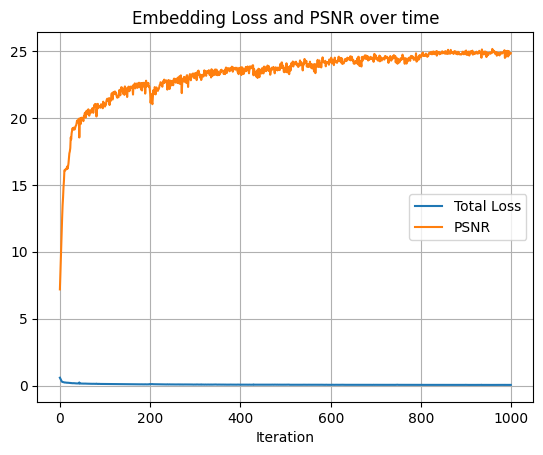

[PSNR LOSS]24.912603697739293


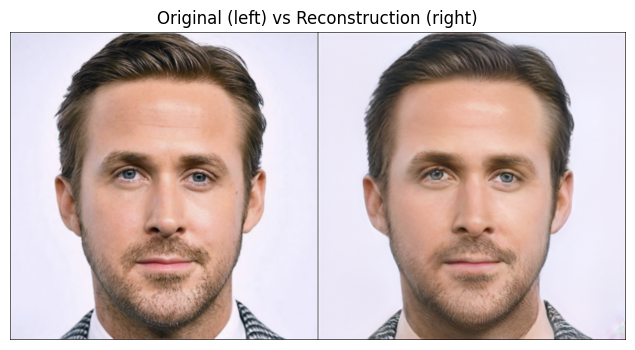

Beginning noise optimization...


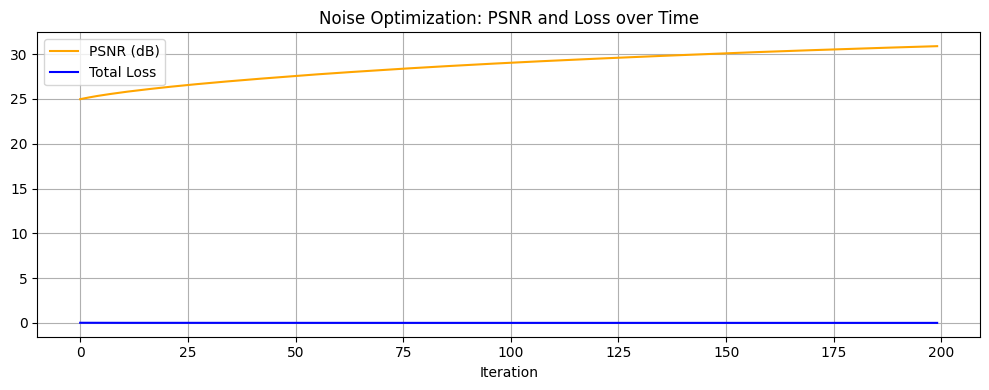

noise optimization complete.


In [13]:
#Check generated images from 10 randomly generated faces
"""Code in embed algo
rnd = np.random.RandomState(7)
z = torch.randn((1,512), requires_grad= True, device= device)
img1 = g_all(z)
img1 = (img1+1.0)/2.0
latents = g_mapping(z)
latents = torch.tensor(latents, requires_grad=True)
save_image(img1.clamp(0,1),"Random/random_image{}.png".format(i))"""

from torchvision import transforms
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import copy

resize_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    ToTensor()
])

def preprocess_to_tensor(image_tensor):
    pil_image = ToPILImage()(image_tensor.squeeze(0).cpu().clamp(0, 1))
    resized_tensor = resize_transform(pil_image).unsqueeze(0).to(device)
    return resized_tensor

image = preprocess_to_tensor(image)
latent1 = embedding_function(image)

with torch.no_grad():
    pre_noise = g_synthesis(latent1)  # or latent2
    pre_noise = (pre_noise + 1.0) / 2.0
    pre_noise = pre_noise.clamp(0,1)
    save_image(pre_noise, "obama-reconstruct.png")

original_img = image.clone().detach().cpu()
if original_img.max() > 1:
    original_img = original_img / 255.0

original_img = image.clone().detach().to(pre_noise.device)

psnr = calculate_psnr(original_img, pre_noise) # calc psnr before doing optimize_noise because will affect original image

original_img = image.clone().detach().cpu()
comparison = make_grid(torch.cat([original_img,pre_noise.cpu()], dim=0), nrow=2)
print(f"[PSNR LOSS]{psnr}")

plt.figure(figsize=(8, 4))
plt.title("Original (left) vs Reconstruction (right)")
plt.axis("off")
plt.imshow(comparison.permute(1, 2, 0).clamp(0, 1).numpy())
plt.show()

optimized_noise1 = optimize_noise(g_synthesis, latent1, image)


Post-optimization noise stds:
Layer 0: 1.151796
Layer 1: 1.923979
Layer 2: 1.565929
Layer 3: 1.770104
Layer 4: 1.913426
Layer 5: 2.525843
Layer 6: 2.295063
Layer 7: 2.463502
Layer 8: 1.561362
Layer 9: 1.979681
Layer 10: 1.472786
Layer 11: 1.516878
Layer 12: 1.387533
Layer 13: 1.083578
Layer 14: 1.299732
Layer 15: 1.102070
Layer 16: 1.056464
Layer 17: 0.877056
[PSNR LOSS]30.90391602792773


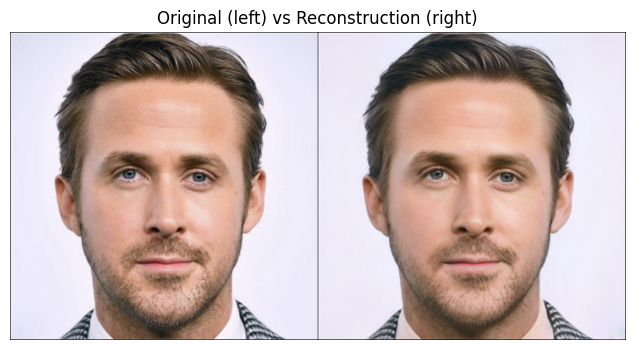

In [14]:
# #noise opt generation
set_noise_maps(g_synthesis, optimized_noise1)

print("Post-optimization noise stds:")
for i, noise in enumerate(optimized_noise1):
    print(f"Layer {i}: {noise.std().item():.6f}")

with torch.no_grad():
    post_noise = g_synthesis(latent1)  # or latent2
    post_noise = (post_noise + 1.0) / 2.0
    post_noise = post_noise.clamp(0,1)
    save_image(post_noise, "rg-reconstruct-noisemap.png")

original_img = image.clone().detach().cpu()
if original_img.max() > 1:
    original_img = original_img / 255.0

comparison = make_grid(torch.cat([original_img, post_noise.cpu()], dim=0), nrow=2)
original_img = image.clone().detach().to(post_noise.device)
print(f"[PSNR LOSS]{calculate_psnr(original_img, post_noise)}")
original_img = image.clone().detach().cpu()

plt.figure(figsize=(8, 4))
plt.title("Original (left) vs Reconstruction (right)")
plt.axis("off")
plt.imshow(comparison.permute(1, 2, 0).clamp(0, 1).numpy())
plt.show()

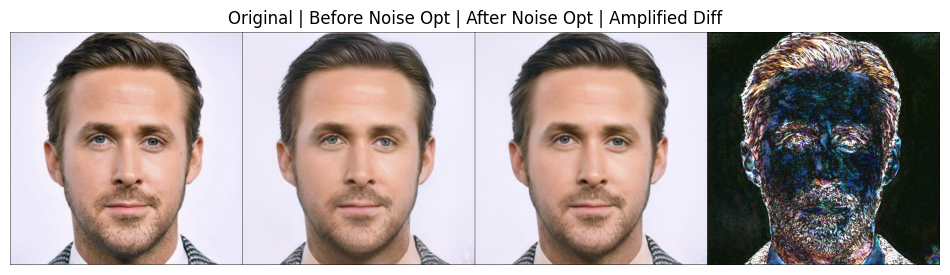

In [15]:
import matplotlib.pyplot as plt

pre_noise_img = pre_noise
post_noise_img = post_noise

diff_map = torch.abs(post_noise_img - pre_noise_img)
amplified_diff = (diff_map * 10).clamp(0, 1)
device = pre_noise_img.device

def show_images(original, before, after, diff):
    original = original if original.ndim == 4 else original.unsqueeze(0)
    before = before if before.ndim == 4 else before.unsqueeze(0)
    after = after if after.ndim == 4 else after.unsqueeze(0)
    diff = diff if diff.ndim == 4 else diff.unsqueeze(0)

    original = original.to(device)
    before = before.to(device)
    after = after.to(device)
    diff = diff.to(device)

    images = torch.cat([original, before, after, diff], dim=0)
    grid = make_grid(images, nrow=4)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title("Original | Before Noise Opt | After Noise Opt | Amplified Diff")
    plt.axis("off")
    plt.show()

show_images(original_img, pre_noise_img, post_noise_img, amplified_diff)


# Contribution 2: Spatial Masking Part 1 - local edits with scribbles

In [16]:
def compute_perceptual_loss(gen_img, real_img):
    vgg = VGG16_perceptual().to(gen_img.device).eval()
    upsample = torch.nn.Upsample(scale_factor=256/1024, mode='bilinear')

    gen_p = upsample(gen_img)
    real_p = upsample(real_img)

    g0, g1, g2, g3 = vgg(gen_p)
    r0, r1, r2, r3 = vgg(real_p)

    loss = 0
    for g, r in zip([g0, g1, g2, g3], [r0, r1, r2, r3]):
        loss += F.mse_loss(g, r)

    return loss


In [17]:
def masked_optimize(
    generator,
    w_plus,
    target_image,
    wm_mask=None,
    w_prior=None,
    lambda_reg=0.01,
    num_steps=1000,
    lr_wplus=0.1,
    lambda_p=10e-5,
    lambda_mse1=10e-5,
    vgg_model = None
):
    device = w_plus.device
    latent = w_plus.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([latent], lr=lr_wplus, betas=(0.9, 0.999),eps=1e-8)

    for step in range(num_steps):
        optimizer.zero_grad()

        if n_ini is not None:
            set_noise_maps(generator, n_ini)

        generated = generator(latent)
        generated = (generated + 1.0) / 2.0
        generated = generated.clamp(0, 1)

        pixel_loss = F.mse_loss(generated, target_image)

        perceptual_loss = torch.tensor(0.0, device=device)
        if vgg_model is not None:
            perceptual_loss = compute_perceptual_loss(generated, target_image)

        reg_loss = torch.tensor(0.0, device=device)
        if w_prior is not None:
            reg_loss = F.mse_loss(latent, w_prior)

        total_loss = lambda_mse1 * pixel_loss + lambda_p * perceptual_loss + lambda_reg * reg_loss
        total_loss.backward()

        if wm_mask is not None:
            with torch.no_grad():
                latent.grad *= wm_mask

        optimizer.step()

        if step % 200 == 0 or step == num_steps - 1:
            print(f"[Step {step}] Pixel Loss: {pixel_loss.item():.6f} | Perceptual Loss: {perceptual_loss.item():.6f}")

    return latent.detach()


In [18]:
import torchvision.transforms.functional as TF
import cv2
import numpy as np

def make_layer_mask(latent, editable_layers=(0, 6), per_channel=True):
    if per_channel:
        wm = torch.zeros_like(latent)
        wm[:, editable_layers[0]:editable_layers[1], :] = 1.0
    else:
        wm = torch.zeros(latent.shape[1], device=latent.device)
        wm[editable_layers[0]:editable_layers[1]] = 1.0
    return wm

def extract_scribble_mask(original_img, scribbled_img, threshold=0.05):
    orig = TF.to_pil_image(original_img.squeeze().cpu())
    scrib = TF.to_pil_image(scribbled_img.squeeze().cpu())

    orig_lab = cv2.cvtColor(np.array(orig), cv2.COLOR_RGB2LAB).astype(np.float32)
    scrib_lab = cv2.cvtColor(np.array(scrib), cv2.COLOR_RGB2LAB).astype(np.float32)

    diff = np.mean(np.abs(scrib_lab - orig_lab), axis=2, keepdims=True)
    mask_np = (diff > (threshold * 255)).astype(np.float32)

    return torch.tensor(mask_np).permute(2, 0, 1).unsqueeze(0)

def blur_mask(mask, kernel_size=15, sigma=4):
    mask_np = mask.squeeze().cpu().numpy().astype(np.float32)
    blurred_np = cv2.GaussianBlur(mask_np, (kernel_size, kernel_size), sigma)

    blurred = torch.tensor(blurred_np).unsqueeze(0).unsqueeze(0).to(mask.device)
    return blurred.clamp(0, 1)


SCRIBBLE EDITING!!

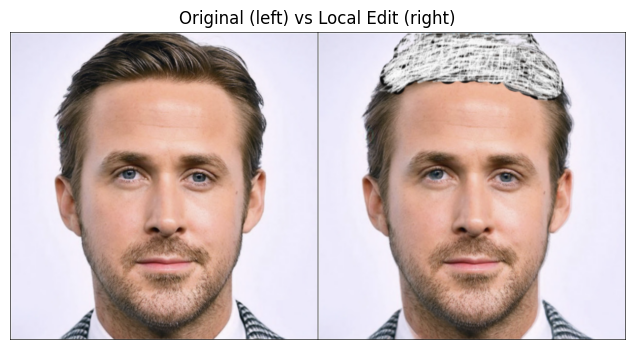

[Step 0] Pixel Loss: 0.026886 | Perceptual Loss: 2.311059


In [ ]:
""" algorithm:

1  (w*, n_ini) ← initialize();
2  w_out = Wl(Mblur, Mblur, 1, w*, n_ini, I1)
       + Mst(1 − Mblur, w*, n_ini, I2);
3  n_out = Mkn(Mblur, w_out, n_ini, I1, G(w_out));

"""
# The paper assumes the generator learns to interpret the scribble during optimization — not to literally copy it.
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

w_star = latent1
n_ini = [torch.randn_like(n) for n in extract_noise_maps(g_synthesis)] # randomized

scribbled_image_path = 'images/hair.png' # source image

with open(scribbled_image_path,"rb") as f:
  imageS=Image.open(f)
  imageS=imageS.convert("RGB")

transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor()
])

imageS = transform(imageS).unsqueeze(0).to(device)
mask = extract_scribble_mask(image, imageS) # source mask

if mask.dim() == 3:
    mask = mask.unsqueeze(0)
elif mask.dim() == 2:
    mask = mask.unsqueeze(0).unsqueeze(0)

mask = F.interpolate(mask.float(), size=(1024, 1024), mode='bilinear', align_corners=False)

device = w_star.device

imageS = imageS.to(device)
mask = mask.to(device)

wm_mask = make_layer_mask(w_star, (0, 6))

m_blur = blur_mask(mask)

I_src = m_blur * imageS + (1 - m_blur) * image

comparison = make_grid(torch.cat([original_img, I_src.cpu()], dim=0), nrow=2)

plt.figure(figsize=(8, 4))
plt.title("Original (left) vs Local Edit (right)")
plt.axis("off")
plt.imshow(comparison.permute(1, 2, 0).clamp(0, 1).numpy())
plt.show()

vgg_model = VGG16_perceptual().to(device).eval()

w_out = masked_optimize (
    generator=g_synthesis,
    w_plus=w_star, # og latent
    w_prior = w_star,
    target_image=I_src, # needs to be target image
    lambda_reg = 0.1,
    num_steps = 1000,
    wm_mask = wm_mask,
    vgg_model = vgg_model
)

with torch.no_grad():
    syn_img = g_synthesis(w_out)
    syn_img = (syn_img + 1.0) / 2.0
    syn_img = syn_img.clamp(0, 1)
    save_image(syn_img, "scribbleH.png")

output_image = mask * syn_img + (1 - mask) * image
output_image = output_image.clamp(0, 1)
save_image(output_image, "scribble_blendH.png")

original_img = image.clone().detach().cpu()
if original_img.max() > 1:
    original_img = original_img / 255.0

comparison = make_grid(torch.cat([original_img, output_image.cpu()], dim=0), nrow=2)

plt.figure(figsize=(8, 4))
plt.title("Original (left) vs Local Edit (right)")
plt.axis("off")
plt.imshow(comparison.permute(1, 2, 0).clamp(0, 1).numpy())
plt.show()


In [ ]:
import torch
import torch.nn.functional as F

def masked_noise_optimize(generator, w_fixed, target_image, base_image, mm_mask,
                          num_steps=500,
                          lr_noise=5,
                          normalize_every=50,
                          lambda_mse1=10e-5,
                          lambda_mse2=10e-5):
    device = w_fixed.device

    w_fixed = w_fixed.detach()

    _ = generator(w_fixed)

    initial_noises = extract_noise_maps(generator) # get the set noise maps
    if len(initial_noises) == 0:
        raise RuntimeError("No noise maps found. Ensure the generator uses NoiseLayer modules and a forward pass has been made.")

    noise_maps = [n.clone().detach().to(device).requires_grad_(True) for n in initial_noises] # make sure on the same device
    optimizer = torch.optim.Adam(noise_maps, lr=lr_noise, betas=(0.9, 0.999),eps=1e-8)

    for step in range(num_steps):
        optimizer.zero_grad()
        set_noise_maps(generator, noise_maps)

        generated = generator(w_fixed)
        generated = (generated + 1.0) / 2.0
        generated = generated.clamp(0, 1)

        if mm_mask.shape[-2:] != generated.shape[-2:]:
            mask = F.interpolate(mm_mask, size=generated.shape[-2:], mode='bilinear', align_corners=False)
        else:
            mask = mm_mask
        if mask.shape[1] == 1:
            mask = mask.expand(-1, 3, -1, -1)

        numPixelON = mask.sum() + 1e-8  #prevent divide-by-zero
        numPixelOFF = (1 - mask).sum() + 1e-8

        loss_on = ((generated - target_image) ** 2 * mask).sum() / numPixelON
        loss_off = ((generated - base_image) ** 2 * (1 - mask)).sum() / numPixelOFF

        total_loss = lambda_mse2 * loss_on + lambda_mse1 * loss_off # add mask + inverse
        total_loss.backward()
        optimizer.step()

        if (step + 1) % normalize_every == 0:
            with torch.no_grad():
                for n in noise_maps:
                    n -= n.mean()
                    n /= (n.std() + 1e-8)

        if step % 100 == 0 or step == num_steps - 1:
            print(f"[Step {step}] Loss on: {loss_on.item():.6f} | Loss off: {loss_off.item():.6f}")

    return [n.detach() for n in noise_maps]



In [ ]:
device = w_star.device

mask = mask.to(device)
n_out = masked_noise_optimize(
    generator=g_synthesis,
    w_fixed = w_out,
    target_image=imageS, # needs to be target image
    base_image = output_image,
    mm_mask=m_blur,
    num_steps = 500
)

In [ ]:
set_noise_maps(g_synthesis, n_out)

with torch.no_grad():
    syn_img = g_synthesis(w_out)
    syn_img = (syn_img + 1.0) / 2.0
    syn_img = syn_img.clamp(0, 1)
    save_image(syn_img, "scribble-noise-bama.png")

if mask.shape[-2:] != syn_img.shape[-2:]:
    mask = F.interpolate(mask, size=syn_img.shape[-2:], mode='bilinear', align_corners=False)

if mask.shape[1] == 1:
    mask = mask.expand(-1, 3, -1, -1)

output_imageN = mask * syn_img + (1 - mask) * image
output_imageN = output_imageN.clamp(0, 1)
save_image(output_imageN, "scribble_blend_noise0bama.png")

original_img = image.clone().detach().cpu()
if original_img.max() > 1:
    original_img = original_img / 255.0

comparison = make_grid(torch.cat([original_img, output_imageN.cpu()], dim=0), nrow=2)

plt.figure(figsize=(8, 4))
plt.title("Original (left) vs Local Edit (right)")
plt.axis("off")
plt.imshow(comparison.permute(1, 2, 0).clamp(0, 1).numpy())
plt.show()

In [ ]:
import matplotlib.pyplot as plt

pre_noise_img = output_image
post_noise_img = output_imageN

diff_map = torch.abs(post_noise_img - pre_noise_img)
amplified_diff = (diff_map * 10).clamp(0, 1)  # Make small changes more visible


def show_images(before, after, diff):
    images = torch.cat([before, after, diff], dim=0)
    grid = make_grid(images, nrow=3)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title("Before Noise Opt | After Noise Opt | Amplified Diff")
    plt.axis("off")
    plt.show()

show_images(pre_noise_img, post_noise_img, amplified_diff)


# Contribution 2: Spatial Masking Part 2 - Style Transfer

In [ ]:
''' Read data images from the image folder and modify shape for later operations 
'''

# Read the base image to be modified. This is stored under image
img_path = 'images/ryan_gosling.png'
with open(img_path,"rb") as f:
  image=Image.open(f)
  image=image.convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)
print(image.shape)

# Read the reference image to be modified. This is stored under image1 
img_path = 'images/meat.png'
with open(img_path,"rb") as f:
  image1=Image.open(f)
  image1=image1.convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
image1 = transform(image1)
image1 = image1.unsqueeze(0)
image1 = image1.to(device)
print(image1.shape)

# Printed shape values can be used to verify sizes and adjust for any future operations

In [ ]:
'''
DEFINING OPTIMIZATION FUNCTIONS
'''
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torchvision.transforms as transforms


def compute_masked_style_loss(gen_img, style_img, mask):
    """
    compute style loss (Gram matrix) between generated and style image in mask

    """
    vgg = VGG16_perceptual(requires_grad=False).to(gen_img.device).eval()

    with torch.no_grad():
        style_feats = vgg(style_img)
    
    # get features from the vgg
    gen_feats = vgg(gen_img)

    loss = 0.0

    for i, (gf, sf) in enumerate(zip(gen_feats, style_feats)):
        B, C, H, W = gf.shape

        # reshape mask in case of error 
        if mask.shape[-2:] != (H, W):
            mask_resized = F.interpolate(mask, size=(H, W), mode='bilinear', align_corners=False)
        else:
            mask_resized = mask

        gf_masked = gf * mask_resized
        sf_masked = sf * mask_resized

        Gg = gram_matrix(gf_masked)
        Gs = gram_matrix(sf_masked)

        # doing the squared differences 
        loss += F.mse_loss(Gg, Gs)


    return loss

def gram_matrix(features):
    (B, C, H, W) = features.size()
    features = features.view(B, C, H * W)

    # batch mat mul 
    G = torch.bmm(features, features.transpose(1, 2))  
    # dividing that by channels 
    return G / (C * H * W)





def masked_style_transfer_optimize(generator, w_target, reference_image, mm_mask,
                                   num_steps=500,
                                   lr=0.01,
                                   normalize_every=20):
    """
    Masked Style Transfer (Mst): Optimize w to match the style of a reference image in the masked region.

    """

    device = w_target.device
    latent = w_target.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([latent], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()

        generated = generator(latent)
        generated = (generated + 1.0) / 2.0  

        # compute masked style loss
        style_loss =  compute_masked_style_loss(generated, reference_image, mm_mask)

        # backprop and take a step 
        style_loss.backward()
        optimizer.step()

        if step % 100 == 0 or step == num_steps - 1:
            print(f"[Style Transfer Step {step}] Style Loss: {style_loss.item():.8f}")

    return latent.detach(), None


In [ ]:
'''
DEFINING MASK EXTRACTING FUNCTION
'''

from PIL import Image
import torch
import torchvision.transforms as transforms
import cv2

def load_mm_mask(scribbled_image_path, threshold =0.05):
    # Black mask extraction to binary mask 

    blur_kernel_size = 25
    blur_sigma = 10

    img = Image.open(scribbled_image_path).convert('RGB')
    img_tensor = transforms.ToTensor()(img)


    mask = (img_tensor[0] < threshold) & (img_tensor[1] < threshold) & (img_tensor[2] < threshold)
    mask = mask.float().cpu().numpy()

    # gaussion blur! 
    blurred = cv2.GaussianBlur(mask, (blur_kernel_size, blur_kernel_size), blur_sigma)
    blurred = blurred / (blurred.max() + 1e-8)

    return torch.tensor(blurred).unsqueeze(0).float() 



In [ ]:
'''
THIS CELL GENERATES THE FINAL IMAGES 

'''

import matplotlib.pyplot as plt

scribbled_image_path = 'images/ryan_scribble.png' 
mm_mask = load_mm_mask(scribbled_image_path) 


# extracting latent by calling functions
image = preprocess_to_tensor(image)
latent1 = embedding_function(image)

w_target = latent1 

# double check and edit mask dimensions in case of bug 
if mm_mask.dim() == 3:
    mm_mask = mm_mask.unsqueeze(0)  
elif mm_mask.dim() == 2:
    mm_mask = mm_mask.unsqueeze(0).unsqueeze(0)  

# change mask size to match 
mm_mask = F.interpolate(mm_mask, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)
image1 = preprocess_to_tensor(image1)

# optimize w+ in specific region
outside_latent, _ = masked_optimize(generator=g_synthesis,
                                     w_plus=w_target,
                                     target_image=image,
                                     mm_mask= (1 -mm_mask))

# opimize for style loss is specifc region 

optimized_latent, _ = masked_style_transfer_optimize(
    generator=g_synthesis,
    w_target=w_target,
    reference_image=image1,           
    mm_mask=mm_mask,
)

# do noise optimization 
optimized_noise2 = optimize_noise(g_synthesis, optimized_latent, image1, mm_mask)

set_noise_maps(g_synthesis, optimized_noise2)

# Make final 
with torch.no_grad():
    final_img = g_synthesis(optimized_latent)
    final_img = (final_img + 1.0) / 2.0
    final_img = final_img.clamp(0, 1)

with torch.no_grad():
    original_img = g_synthesis(outside_latent)
    original_img = (original_img + 1.0) / 2.0

output_image = final_img

# using the output image and the original_image make final

backgroundA = (1 - mm_mask) * original_img

# Build
regionB = mm_mask * output_image
hybrid_target = regionB + backgroundA
comparison = make_grid(torch.cat([ hybrid_target.cpu()], dim=0), nrow=2)

save_image(hybrid_target, "style_transfer_who.png")

plt.figure(figsize=(8, 4))
plt.title("Original (left) vs Local Style Transfer (right)")
plt.axis("off")
plt.imshow(comparison.permute(1, 2, 0).clamp(0, 1).numpy())
plt.show()



## Modify Activation

In [ ]:
def get_block_key_from_index(layer_idx):
    """
    Converts a numerical layer index (e.g., 0, 1, 2) to the corresponding resolution key
    used in g_synthesis.blocks (e.g., '4x4', '8x8', '16x16', ...).

    Args:
        layer_idx (int): Index of the block (0 = 4x4, 1 = 8x8, ..., 9 = 1024x1024)

    Returns:
        str: Resolution string key for ModuleDict lookup
    """
    resolution = 2 ** (layer_idx + 2)  # Starts at 4x4 → 2^2
    return f'{resolution}x{resolution}'

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def load_mm_mask(mask_path, grayscale_threshold=0.5):
    """
    Load a grayscale image convert it into a binary mask tensor (1 where mask applies, 0 elsewhere).

    Args:
        mask_path (str): Path to the mask image (grayscale or RGB).
        threshold (float): Threshold for binarization (between 0 and 1).

    Returns:
        torch.Tensor: Binary mask of shape (1, 1, H, W) with values 0 or 1.
    """
    # Load image and convert to tensor
    img = Image.open(mask_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img)
    mask = img_tensor > grayscale_threshold

    # Convert to float tensor and add batch/channel dimensions (1, 1, H, W)
    return mask.float().unsqueeze(0)

In [ ]:
scribbled_image_path = 'images/horizontal_mask.png' # source image
mask = load_mm_mask(scribbled_image_path) # source mask
if mask.shape[1] == 3:
  mask = mask.mean(dim=1, keepdim=True)  # Grayscale
mask = mask.to(image.device)

print(mask)

In [ ]:
import copy

# Step 1: Embed and optimize noise
g_synthesis_A = copy.deepcopy(g_synthesis).to(device)
g_synthesis_B = copy.deepcopy(g_synthesis).to(device)

w_A = embedding_function(image)
n_A = optimize_noise(g_synthesis_A, w_A, image)

w_B = embedding_function(image1)
n_B = optimize_noise(g_synthesis_B, w_B, image1)

In [ ]:
# Step 2: Run synthesis and get activations
set_noise_maps(g_synthesis_A, n_A)
img_A, acts_A = g_synthesis_A(w_A, return_activations=True)

set_noise_maps(g_synthesis_B, n_B)
img_B, acts_B = g_synthesis_B(w_B, return_activations=True)

In [ ]:
# Quick Sanity Check
from torchvision.utils import make_grid
with torch.no_grad():
    syn_img = g_synthesis_A(w_A)  # or latent2
    syn_img = (syn_img + 1.0) / 2.0
    syn_img = syn_img.clamp(0,1)
    save_image(syn_img, "obamareconstruct-noisemap.png")

# Ensure the original is scaled to [0, 1] too
original_img = image.clone().detach().cpu()
if original_img.max() > 1:
    original_img = original_img / 255.0

# Make grid: [original | reconstruction]
comparison = make_grid(torch.cat([original_img, syn_img.cpu()], dim=0), nrow=2)

# Plot
plt.figure(figsize=(8, 4))
plt.title("Original (left) vs Reconstruction (right)")
plt.axis("off")
plt.imshow(comparison.permute(1, 2, 0).clamp(0, 1).numpy())
plt.show()

In [ ]:
import os
import re

os.makedirs("masked_activation_edit", exist_ok=True)

# Get all layer keys from the synthesis network
all_layer_keys = list(g_synthesis.blocks.keys())

# Loop through each layer
for idx, layer_key in enumerate(all_layer_keys):
    print(f"Processing layer {idx}: {layer_key}")

    # Get the corresponding activation tensors
    target_shape = acts_A[idx].shape[-2:]
    mask_resized = F.interpolate(mask, size=target_shape, mode='nearest')
    mask_expanded = mask_resized.expand_as(acts_A[idx]).to(acts_A[idx].device)

    # Blend activations
    blended_act = mask_expanded * acts_A[idx] + (1 - mask_expanded) * acts_B[idx]

    def create_hook(module, input, output):
        output.copy_(blended_act)

    hook = g_synthesis.blocks[layer_key].register_forward_hook(create_hook)

    # Blend global and local features, weighted average of W+ latent space
    weight = 0.3
    w_blended = weight * w_A + (1 - weight) * w_B

    # Use style from blend (latent code w_blended), inject only the activation at this layer
    set_noise_maps(g_synthesis, n_A)
    with torch.no_grad():
        edited_img = g_synthesis(w_blended).clamp(-1, 1)
        edited_img = (edited_img + 1.0) / 2.0  # Convert to [0, 1]

    # Save each image
    save_path = f"masked_activation_edit/edited_layer_{layer_key}.png"
    save_image(edited_img, save_path)

    # Clean up hook
    hook.remove()

def extract_layer_number(filename):
    match = re.search(r"layer_(\d+)", filename)
    return int(match.group(1)) if match else float('inf')

# Directory with edited images
img_dir = "masked_activation_edit"
img_files = sorted(os.listdir(img_dir), key=extract_layer_number)

# Load images
images = [Image.open(os.path.join(img_dir, fname)) for fname in img_files]

# Set up the display grid
n_cols = 4
n_rows = (len(images) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Display images in grid
for ax, img, fname in zip(axs.flatten(), images, img_files):
    ax.imshow(img)
    ax.set_title(fname.split(".")[0], fontsize=10)
    ax.axis('off')

# Hide any unused subplots
for ax in axs.flatten()[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()